# 1. Introduction

#### Unfortunately, credit card fraud occurs everyday all over the world. However, credit card companies have made significant progress in detecting these occurences in order to protect their customers. This dataset contains credit card transactions made in September 2013 in Europe over two days.

#### The goal of this notebook is to detect fraud and predict when they could occur. 

 # 2. Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn import metrics

from matplotlib import pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import plotly.express as px

import seaborn as sns
import random

In [2]:
df_train_original = pd.read_csv(r"/Users/satmeerbains/Documents/Python/Financial_Fraud/Financial_Fraud_data/fraudTrain.csv")

df_train_original.drop(df_train_original.columns[0], axis=1, inplace=True)

df_test_original = pd.read_csv(r"/Users/satmeerbains/Documents/Python/Financial_Fraud/Financial_Fraud_data/fraudTest.csv")

df_test_original.drop(df_test_original.columns[0], axis=1, inplace=True)

# In order to seperate test and training subsets later on in the notebook
df_original = pd.concat([df_train_original,df_test_original], axis = 0)

In [3]:
# Define the proportion of the sample size we want
sample_size = 0.15  

# Performing stratified sampling
df, _ = train_test_split(df_train_original, test_size=1-sample_size, stratify=df_train_original['is_fraud'], random_state=42)

# Displaying the sampled DataFrame
df.shape

(194501, 22)

# 3. EDA

## 3.1 Data Description
#### We'll first create a custom function that shows us the data type, % missing data, and number of unique values for each feature in the dataframe

In [4]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
print(df.shape)

df_explore(df).head(10)

(194501, 22)


,column,dtype,%_missing,nunique
17,trans_num,object,0.0,194501
20,merch_long,float64,0.0,194042
18,unix_time,int64,0.0,194009
0,trans_date_trans_time,object,0.0,194008
19,merch_lat,float64,0.0,193373
4,amt,float64,0.0,26167
1,cc_num,int64,0.0,968
8,street,object,0.0,968
11,zip,int64,0.0,957
13,long,float64,0.0,956


## 3.2 Data Balance Check
#### When dealing with binary target features, it's always good to determine if the data is balanced or not

Text(0.5, 1.0, '% of Fraudulent vs Non-fraudulent transactions')

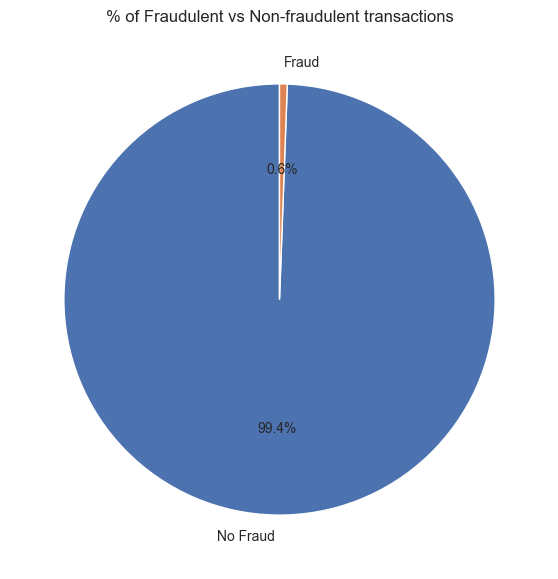

In [5]:
df['is_fraud_cat'] = df['is_fraud'].apply(lambda x: "Fraud" if x==1 else "No Fraud")

is_fraud_values = df['is_fraud_cat'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(is_fraud_values, labels=is_fraud_values.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("deep", n_colors=len(is_fraud_values)))
plt.title('% of Fraudulent vs Non-fraudulent transactions')

#### We can see that we have highly unbalanced data. This represents a severe skew in the class distribution. We have some methods to help alleviate this issue.

## 3.3 Fraud by Transaction Category

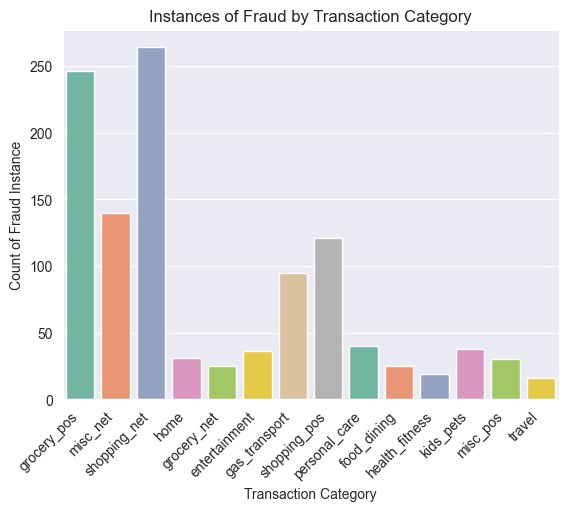

<Figure size 700x700 with 0 Axes>

In [6]:
sns.countplot(x="category", data=df[df['is_fraud_cat']=="Fraud"], palette="Set2", hue = 'category')

plt.title('Instances of Fraud by Transaction Category')
plt.xlabel('Transaction Category')
plt.ylabel('Count of Fraud Instance')
plt.xticks(rotation=45, ha = 'right')
plt.figure(figsize=(7, 7))
plt.show()

### 3.4 Fraud by Job

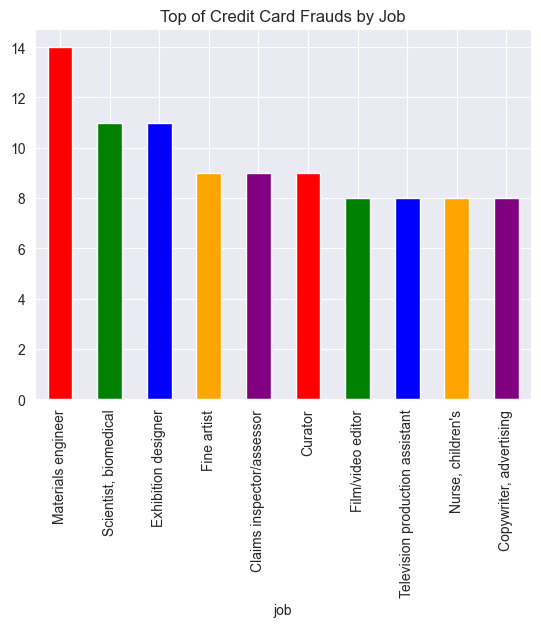

In [7]:
df[df['is_fraud_cat']=="Fraud"]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar",x='job', y=df['is_fraud_cat']=="Fraud", color=['red', 'green', 'blue', 'orange', 'purple'])
plt.title("Top of Credit Card Frauds by Job")
plt.show()

# 4. Data Pre-processing

## 4.1.1  Dropping duplicated values
#### A first simple step in cleaning the dataset is to remove any duplicate values

In [8]:
df2 = df.copy()

df2.drop_duplicates(inplace=True)

print("Duplicated values dropped")

Duplicated values dropped


## 4.1.2 Transforming Variables
#### Here we will check whether any variables can be easily transformed

#### Transforming the gender variable to be binary

In [9]:
def gender_transform(x):
    if x=='F':
        return 1
    if x=='M':
        return 0
df2['gender'] = df2['gender'].transform(gender_transform)

## 4.2 Dummy Variables

#### Continuing to process our data for a models, we'll take a look at the categorical data and their number of unique values to determine which we should retain for dummy variables 

In [10]:
df3 = df2.drop(['unix_time','trans_date_trans_time','cc_num','trans_num','street','dob','city','merchant','job','last','first','state','is_fraud_cat'],axis = 1)

In [11]:
df3_dummies = pd.get_dummies(df3.select_dtypes('object'), dtype = int)

df4 = pd.concat([df3.drop(df3.select_dtypes('object').columns, axis = 1), df3_dummies],axis = 1)

print(df4.shape)
df4.head()

(194501, 23)


,amt,gender,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,category_entertainment,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
398918,55.05,0,37849,36.0435,-84.0400,25459,36.175640,-84.646341,0,0,...,0,0,0,1,0,0,0,0,0,0
655541,3.03,0,7208,40.6747,-74.2239,124967,40.939505,-74.256242,0,0,...,0,0,0,0,0,1,0,0,0,0
911788,139.01,1,45342,39.6321,-84.2675,36784,39.822635,-84.105583,0,1,...,0,0,0,0,0,0,0,0,0,0
86389,55.74,1,29032,34.3424,-80.5000,4424,34.962050,-80.168628,0,0,...,0,0,0,0,0,0,0,0,0,0
289156,93.78,1,73559,34.7032,-98.9591,540,34.068722,-98.940711,0,0,...,1,0,0,0,0,0,0,0,0,0


## 4.3 Stratified Train/Test split

#### We need to generate a training / validation dataset split that will keep the same percentages of classes in each split.

In [12]:
X = df4.reset_index(drop='index').drop('is_fraud', axis=1)

y = df4.reset_index(drop='index')['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

## 4.4 Feature Scaling

In [13]:
# Creating a function for scaling

def Standard_Scaler (df, col_names):

    features = df[col_names]

    scaler = StandardScaler().fit(features.values)

    features = scaler.transform(features.values)

    df[col_names] = features

    return df

col_names = ['amt']

X_train = Standard_Scaler (X_train, col_names)

X_test = Standard_Scaler (X_test, col_names)

# 5. Baseline Model (no imbalance resampling)

#### We'll start with building a baseline random forest model so we can have a reference in how the model performs if we left the data as is.

## 5.1 Random Forest

### 5.1.1 Instantiating the model 

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)

### 5.1.2 Fitting the model

In [15]:
rf.fit(X_train, y_train)
y_pred_baseline = rf.predict(X_test)

### 5.1.3 Performance and Accuracy Scores

In [16]:
print("Performance with imbalanced dataset:")
print(classification_report(y_test, y_pred_baseline))

Performance with imbalanced dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.86      0.56      0.68       338

    accuracy                           1.00     58351
   macro avg       0.93      0.78      0.84     58351
weighted avg       1.00      1.00      1.00     58351



In [17]:
cm = confusion_matrix(y_test, y_pred_baseline)

rf_baseline_Recall = recall_score(y_test, y_pred_baseline)
rf_baseline_Precision = precision_score(y_test, y_pred_baseline)
rf_baseline_f1 = f1_score(y_test, y_pred_baseline)
rf_baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

ndf = [(rf_baseline_Recall, rf_baseline_Precision, rf_baseline_f1, rf_baseline_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest performed with', 'Original (Imbalanced Dataset)')
rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.556213,0.862385,0.676259,0.996915


# 6. Random Resampling Methods for Imbalanced Data

## 6.1 Random Oversampling

### 6.1.1 Instantiating the model 

In [18]:
from imblearn.over_sampling import RandomOverSampler
# defining oversampling method
ros = RandomOverSampler(random_state=42)

rf_oversample = RandomForestClassifier(n_estimators=200)
X_train_oversample, y_train_oversample = ros.fit_resample(X_train, y_train)

### 6.1.2 Fitting the Model

In [19]:
rf_oversample.fit(X_train_oversample, y_train_oversample)
y_pred_oversample = rf_oversample.predict(X_test)

### 6.1.3 Performance and Accuracy Scores

In [20]:
print("Performance with Random Oversampling:")
print(classification_report(y_test, y_pred_oversample))

Performance with Random Oversampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.78      0.65      0.71       338

    accuracy                           1.00     58351
   macro avg       0.89      0.82      0.85     58351
weighted avg       1.00      1.00      1.00     58351



In [21]:
cm = confusion_matrix(y_test, y_pred_oversample)

oversample_rf_Recall = recall_score(y_test, y_pred_oversample)
oversample_rf_Precision = precision_score(y_test, y_pred_oversample)
oversample_rf_f1 = f1_score(y_test, y_pred_oversample)
oversample_rf_accuracy = accuracy_score(y_test, y_pred_oversample)

ndf_over = [(oversample_rf_Recall, oversample_rf_Precision, oversample_rf_f1, oversample_rf_accuracy)]

oversample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
oversample_rf_score.insert(0, 'Random Forest performed with', 'Random Oversampling')
oversample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Oversampling,0.647929,0.779359,0.707593,0.996898


## 6.2 Random Undersampling

### 6.2.1 Instantiate the model 

In [22]:
from imblearn.under_sampling import RandomUnderSampler
# defining oversampling method
rus = RandomUnderSampler(random_state=42)

rf_undersample = RandomForestClassifier(n_estimators=200)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

### 6.2.2 Fitting the Model

In [23]:
rf_undersample.fit(X_train_undersample, y_train_undersample)
y_pred_undersample = rf_undersample.predict(X_test)

### 6.2.3 Performance and Accuracy Scores

In [24]:
print("Performance with Random Undersampling:")
print(classification_report(y_test, y_pred_undersample))

Performance with Random Undersampling:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58013
           1       0.11      0.93      0.20       338

    accuracy                           0.96     58351
   macro avg       0.56      0.94      0.59     58351
weighted avg       0.99      0.96      0.97     58351



In [25]:
cm = confusion_matrix(y_test, y_pred_undersample)

undersample_rf_Recall = recall_score(y_test, y_pred_undersample)
undersample_rf_Precision = precision_score(y_test, y_pred_undersample)
undersample_rf_f1 = f1_score(y_test, y_pred_undersample)
undersample_rf_accuracy = accuracy_score(y_test, y_pred_undersample)

ndf_over = [(undersample_rf_Recall, undersample_rf_Precision, undersample_rf_f1, undersample_rf_accuracy)]

undersample_rf_score = pd.DataFrame(data = ndf_over, columns=['Recall','Precision','F1 Score', 'Accuracy'])
undersample_rf_score.insert(0, 'Random Forest performed with', 'Random Undersampling')
undersample_rf_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Random Undersampling,0.926036,0.11482,0.204308,0.958218


## 6.3 SMOTE (Synthetic Minority Oversampling Technique)¶

### 6.3.1 Instantiate the model 

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 6.3.2 Fitting the Model

In [27]:
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

### 6.3.3 Performance and Accuracy Scores

In [28]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_smote))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     58013
           1       0.11      0.76      0.19       338

    accuracy                           0.96     58351
   macro avg       0.55      0.86      0.58     58351
weighted avg       0.99      0.96      0.98     58351



In [29]:
cm_smote = confusion_matrix(y_test, y_pred_smote)
rf_smote_Recall = recall_score(y_test, y_pred_smote)
rf_smote_Precision = precision_score(y_test, y_pred_smote)
rf_smote_f1 = f1_score(y_test, y_pred_smote)
rf_smote_accuracy = accuracy_score(y_test, y_pred_smote)

ndf = [(rf_smote_Recall, rf_smote_Precision, rf_smote_f1, rf_smote_accuracy)]

rf_smote_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_score.insert(0, 'Random Forest performed with', 'Smote Oversampling')
rf_smote_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Smote Oversampling,0.763314,0.108085,0.189358,0.962143


## 6.4 Tomek & SMOTE

### 6.4.1 Instantiate the model 

In [30]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
SMOTETomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
rf_SMOTETomek = RandomForestClassifier(n_estimators=200)
X_train_SMOTETomek, y_train_SMOTETomek = SMOTETomek.fit_resample(X_train, y_train)

### 6.4.2 Fitting the Model

In [31]:
rf_SMOTETomek.fit(X_train_SMOTETomek,y_train_SMOTETomek)
y_pred_SMOTETomek = rf_SMOTETomek.predict(X_test)

### 6.4.3 Performance and Accuracy Scores

In [32]:
print("Performance with SMOTE:")
print(classification_report(y_test, y_pred_SMOTETomek))

Performance with SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58013
           1       0.79      0.63      0.70       338

    accuracy                           1.00     58351
   macro avg       0.89      0.81      0.85     58351
weighted avg       1.00      1.00      1.00     58351



In [33]:
cm_smote_tomek = confusion_matrix(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Recall = recall_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_Precision = precision_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_f1 = f1_score(y_test, y_pred_SMOTETomek)
rf_smote_tomek_accuracy = accuracy_score(y_test, y_pred_SMOTETomek)

ndf = [(rf_smote_tomek_Recall, rf_smote_tomek_Precision, rf_smote_tomek_f1, rf_smote_tomek_accuracy)]

rf_smote_tomek_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_smote_tomek_score.insert(0, 'Random Forest performed with', 'SMOTE & Tomek')
rf_smote_tomek_score

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,SMOTE & Tomek,0.627219,0.788104,0.698517,0.996864


## 6.5 Performance Summary

In [34]:
rf_sampling_scores = pd.concat([rf_score, oversample_rf_score, undersample_rf_score,rf_smote_score, rf_smote_tomek_score],axis = 0)
rf_sampling_scores

,Random Forest performed with,Recall,Precision,F1 Score,Accuracy
0,Original (Imbalanced Dataset),0.556213,0.862385,0.676259,0.996915
0,Random Oversampling,0.647929,0.779359,0.707593,0.996898
0,Random Undersampling,0.926036,0.114820,0.204308,0.958218
0,Smote Oversampling,0.763314,0.108085,0.189358,0.962143
0,SMOTE & Tomek,0.627219,0.788104,0.698517,0.996864


# 7. Applying best model

## 7.1.1 Showing the accuracy score again

In [35]:
accuracy = accuracy_score(y_test, y_pred_undersample)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 95.82%


## 7.1.2 Print the predicted and actual class names

In [36]:
# remapping the classes 
class_names = {1:'Fraud',0:'No Fraud'}
predicted_classes = [class_names[label] for label in y_pred_undersample]

# Mapping true labels to custom class names
class_map = [class_names[label] for label in y_test]

# Step 10: Print the predicted and actual class names for the first 5 test samples
for i in range(20):
    print(f"Sample {i+1}: True Class: {class_map[i]}, Predicted Class: {predicted_classes[i]}")

Sample 1: True Class: No Fraud, Predicted Class: No Fraud
Sample 2: True Class: No Fraud, Predicted Class: No Fraud
Sample 3: True Class: No Fraud, Predicted Class: No Fraud
Sample 4: True Class: No Fraud, Predicted Class: No Fraud
Sample 5: True Class: No Fraud, Predicted Class: No Fraud
Sample 6: True Class: No Fraud, Predicted Class: No Fraud
Sample 7: True Class: No Fraud, Predicted Class: No Fraud
Sample 8: True Class: No Fraud, Predicted Class: No Fraud
Sample 9: True Class: No Fraud, Predicted Class: No Fraud
Sample 10: True Class: No Fraud, Predicted Class: No Fraud
Sample 11: True Class: No Fraud, Predicted Class: No Fraud
Sample 12: True Class: No Fraud, Predicted Class: No Fraud
Sample 13: True Class: No Fraud, Predicted Class: No Fraud
Sample 14: True Class: No Fraud, Predicted Class: No Fraud
Sample 15: True Class: No Fraud, Predicted Class: No Fraud
Sample 16: True Class: No Fraud, Predicted Class: No Fraud
Sample 17: True Class: No Fraud, Predicted Class: No Fraud
Sample